In [1]:
using DifferentialEquations, PyPlot, Distributions, LaTeXStrings, Statistics

In [2]:
theta = [0.25, 0.1] # γ, λ
T = 30
t = collect(0:1:30)
P0 = 1.0;

In [3]:
simulate(u,p,t) = p[1]*(1+sin(2*π/365*t))*u - p[2]*u^2

simulate (generic function with 1 method)

In [4]:
function loglike(theta, obs)
    u₀ = 2.5;
    tspan = (0.0, T)
    t_obs_ind = [1,3,4,6,9,13,16,24];
    p = [theta[1], 2*π/365, theta[2]]
    prob = ODEProblem(simulate,u₀,tspan,p)
    xhat = solve(prob,reltol=1e-6,saveat=1.0).u
    xhat = xhat[t_obs_ind]
    L = -sum((obs[:,2] .- xhat).^2)
    return L
end

loglike (generic function with 1 method)

In [71]:
theta_ref = [0.25, 0.1]
tspan = (0.0, maximum(t))

prob = ODEProblem(simulate,1.0,tspan,theta_ref)
sol = solve(prob,reltol=1e-6,saveat=1.0)
t_obs_ind = [1,3,4,6,9,13,16,24];
yobs = sol.u[t_obs_ind] + .+ rand(Normal(0,0.1),size(t_obs_ind,1))
obs = hcat(t[t_obs_ind],yobs);

### The H-M MCMC algorithm

In [72]:
# setup
nc = 1000 # number of iterations (length of the chain)
theta_acc = zeros(nc,2) # accumulator for sample (parameter posterior)

thetaold = [0.25, 0.1] # initial condition for chain (parameter values)

# priors (use uniforms so set upper and lower bounds)
gam_low = 0.2
gam_up = 0.3
lam_low = 0.09
lam_up = 0.11;

In [73]:
for i in 1:nc
    # Step 1: Generate Trial Candidate (draw from parameter prior)
    gammac = rand(Uniform(gam_low, gam_up))
    lambdac = rand(Uniform(lam_low, lam_up))
    thetac = [gammac,lambdac]

    # Step 2: Compute acceptance probability for this candidate
    # compute log likelihood for candidate
    like_num = loglike(thetac,obs)

    # compute log likelihood for last member of chain (last sample member)
    like_denom = loglike(thetaold,obs)

    # compute the likelihood ratio
    likeratio = exp(like_num - like_denom)

    # determine acceptance probability
    A = min(1.0,likeratio) 

    # Step 3: Choose whether or not to accept candidate
    # accept candidate with probability A, otherwise revert to previous chain member
    if rand(Uniform()) ≤ A
        thetanew = thetac
    else
        thetanew = thetaold
    end
    
    # add to the sample 
    theta_acc[i,:] = thetanew
    thetaold = thetanew
end

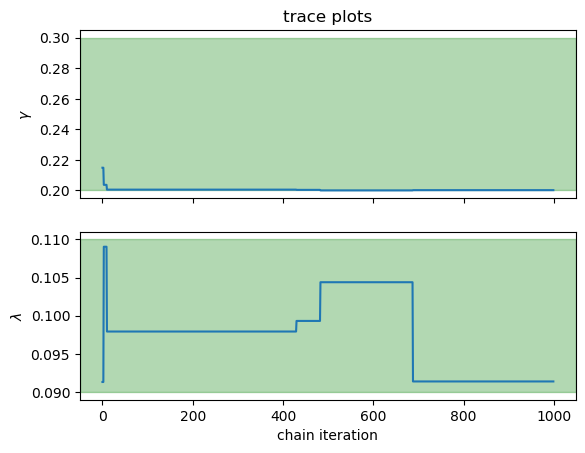

In [74]:
fig, axs = plt.subplots(nrows=2, sharex=true)
axs[1].plot(theta_acc[:,1])
axs[1].axhspan(gam_low, gam_up, color="green", alpha=0.3)
axs[1].set(ylabel=L"\gamma", title="trace plots")
axs[2].plot(theta_acc[:,2])
axs[2].axhspan(lam_low, lam_up, color="green", alpha=0.3)
axs[2].set(ylabel=L"\lambda", xlabel="chain iteration");

In [75]:
using KernelDensity

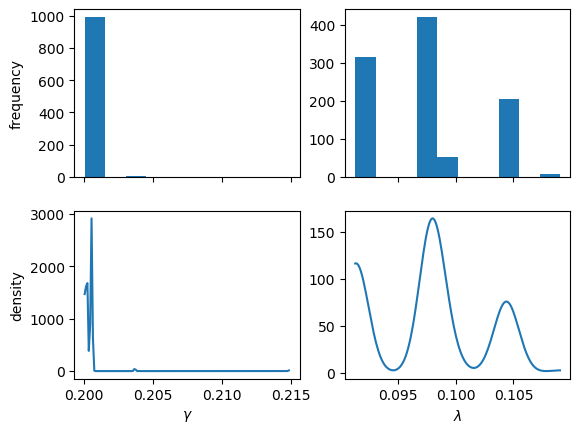

In [76]:
cname = [L"\gamma", L"\lambda"]
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col")
for icol in 1:2
    # histogram
    axs[1,icol].hist(theta_acc[:,icol])
    # kernel smooth density
    ksd = kde(theta_acc[:,icol])
    x = collect(minimum(theta_acc[:,icol]):0.0001:maximum(theta_acc[:,icol]))
    axs[2,icol].plot(x,pdf(ksd,x))
    axs[2,icol].set_xlabel(cname[icol])
    if icol == 1
        axs[1,icol].set_ylabel("frequency")
        axs[2,icol].set_ylabel("density")
    end
end

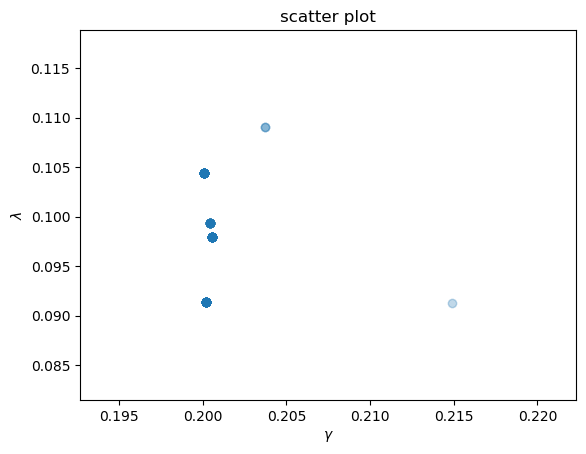

In [77]:
# scatter plot of joint distribution
fig, ax = plt.subplots()
ax.scatter(theta_acc[:,1], theta_acc[:,2],alpha = 0.1)
ax.set(title="scatter plot", xlabel=L"\gamma", ylabel=L"\lambda");